<a href="https://colab.research.google.com/github/andres4640/Fake-News-Tesis/blob/main/FakeNewsBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Tesis/')

In [ ]:
df_one_final = pd.read_csv("Datasets/df_final.csv")

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.1MB 14.8MB/s 
     |████████████████████████████████| 194kB 56.1MB/s 
     |████████████████████████████████| 15.7MB 336kB/s 
     |████████████████████████████████| 10.8MB 39.2MB/s 
     |████████████████████████████████| 296kB 49.4MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 28.5MB 66.2MB/s 
     |████████████████████████████████| 215kB 52.1MB/s 
     |████████████████████████████████| 3.9MB 33.0MB/s 
     |████████████████████████████████| 686kB 40.5MB/s 
     |████████████████████████████████| 358kB 48.0MB/s 
     |████████████████████████████████| 1.2MB 39.1MB/s 
     |████████████████████████████████| 10.3MB 35.1MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
     |████████████████████████████████| 645kB 42.4MB/s 
     |████████████████████████████████| 3.0MB 36.0MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 51kB 9

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 102kB 8.8MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=d1632000fc4503ab12b3eab3382c08b8cee3061255e5b2f264ffad64bf4bbd2d
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
train_df, valid_df = train_test_split(df_one_final, random_state=42, train_size=0.8, stratify=df_one_final.outcome.values)
train_df.shape, valid_df.shape

((10655, 2), (2664, 2))

In [ ]:
X_train = train_df.iloc[:,0].values
y_train = train_df.iloc[:,1].values
X_train = np.reshape(X_train,(X_train.size, 1))
#y_train = np.reshape(y_train, (y_train.size, 1))

## Balanceo del Dataset


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

over = RandomOverSampler(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
print("Antes de aplicar las tecnicas: ", Counter(y_train))
X_train, y_train = over.fit_resample(X_train, y_train)
print("Despues de aplicar Oversampling: ", Counter(y_train))
X_train, y_train = under.fit_resample(X_train, y_train)
print("Despues de aplicar Undersampling: ", Counter(y_train))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Antes de aplicar las tecnicas:  Counter({1: 8627, 0: 2028})
Despues de aplicar Oversampling:  Counter({1: 8627, 0: 3450})
Despues de aplicar Undersampling:  Counter({1: 6900, 0: 3450})


In [ ]:
y_train = np.reshape(y_train, (y_train.size, 1))
y_train.shape

(10350, 1)

In [ ]:
train_data_samp = np.concatenate((X_train, y_train), axis=1 )

In [ ]:
train_data_samp = pd.DataFrame(train_data_samp,
             columns=['headlines', 
                      'outcome'])


In [ ]:
train_df.dtypes

headlines    object
outcome       int64
dtype: object

In [ ]:
train_data_samp.outcome = np.asarray(train_data_samp.outcome).astype(np.float32)

## Preprocesar y Tokenizar 

In [ ]:
with tf.device('/cpu:0'):
  train_data_samp = tf.data.Dataset.from_tensor_slices((train_data_samp.headlines.values, train_data_samp.outcome.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.headlines.values, valid_df.outcome.values))
  train_data = tf.data.Dataset.from_tensor_slices((train_df.headlines.values, train_df.outcome.values))

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
# Ahora instanciar el Tokenizador que realizara el preprocesamiento y tokenizacion de los datos.
  # Requiere el vocabulario de BERT
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

# Asegurarnos que estamos usando la version uncased de BERT -> Cased o Uncased. -> Revisara el archivo almacenado en el Modelo. 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# Instanciamos el Tokenizador
  # Le enviamos el vocabulario y si es un modelo Cased. 
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  # Estructura que BERT usa para crear caracteristicas input
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # guid -> ID unico para cada ejemplo. Como solo tenemos un ejemplo al mismo tiempo sera 1.
    # text_a = texto que queremos clasificar. Como esta en formato texto, usamos la funcion numpy() para obtener sus valores.
    # text_b -> Lo usareiamos si aplicaremos Next Sentence Prediction, pero como no lo usamos seria None. 
    # label -> La etiqueta de nuestro ejemplo.

   # Convertimos el primer ejemplo (numero 0)
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
# Convertiremos la funcion en un tensorflow wrap
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  # to_feature -> Funcion que se convertira a una operacion TF.
    # inp -> Datos input que recibira la funcin
    # Tout -> Especificar el tipo de datos que la funcion retornara. 

  # Debemos especificar el tamaño del tensor que se retornara (Tout)
  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([]) # No sabemos el tamaño de las etiquetas.

  # Diccionario de resultados que se retornara:
  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

    # Num_parallel_calls -> Ejecucion paralela de la funcion map, se pone el numero disponibles de cores con AUTOTUNE.
    # shuffle -> Seleccionara 1000 elementos aleatorios del dataset
    # batch -> Combina datos consecutios en batches. Como drop_remainder es True, se eliminan los datos restauntes que no son batches de 32 elementos.
    # prefetch -> Permite traslapar el preprocesamiento y la ejecucion del modelo de un paso de entrenamiento. 
      # Mientras que el modelo esta ejecutando un paso de entrenamiento "s", el input pipeline esta leyendo para el paso "s+1" -> Reduce el tiempo de los pasos.
      # El numero de elementos a prefetch debe ser igual o mayor al numero de batches. Le ponemos AUTOTUNE para automatizar el paso. 
      
  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 
  
  train_data_samp = (train_data_samp.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

## Modelo BERT

In [ ]:
def BERT_basico():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output) 

  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
   
  return model

In [ ]:
def BERT_create_model(hp):
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])#, name="BERT Layer")

  # Dropout para minimizar Overfitting en el Training Set
  dense = tf.keras.layers.Dropout(hp.Float("dropout_BERT", 0, 0.5, 0.1))(pooled_output) # Hiperparametro con el cual puedes experimentar

  for i in range(hp.Int("n_capas_dense", 0, 5, 1)):
    if i == 0:
      pass
    else:
      dense = tf.keras.layers.Dense(hp.Int(f"dense_units_{i}", 32, 320, 32), 
                                    activation='relu') (dense)
      dense = tf.keras.layers.Dropout(hp.Float(f"dropout_unit_{i}", 0, 0.5, 0.1))(dense)

  output = tf.keras.layers.Dense(1, activation="sigmoid")(dense) # "drop" -> Especificamos que se aplicara esta capa en los resultados de "dropout"
  #output = tf.keras.layers.Dense(1, activation="sigmoid", name="Output Sigmoid")(dense)
  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  
  #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
  #            loss=tf.keras.losses.BinaryCrossentropy(),
  #            metrics=[tf.keras.metrics.BinaryAccuracy()])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss ='binary_crossentropy',
              metrics=['accuracy'])
  #model.summary()

  return model

In [ ]:
model = BERT_basico()

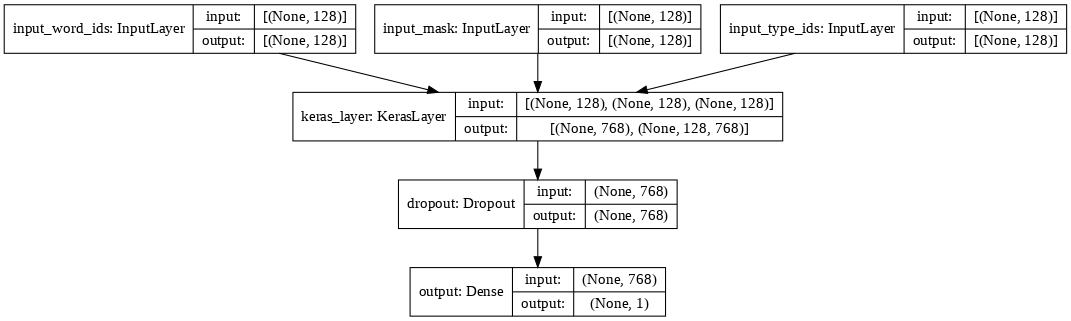

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [ ]:
# Train model
epochs = 5
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/5
332/332 [==============================] - 192s 536ms/step - loss: 0.2427 - binary_accuracy: 0.8899 - val_loss: 0.1713 - val_binary_accuracy: 0.9255
Epoch 2/5
332/332 [==============================] - 178s 535ms/step - loss: 0.1541 - binary_accuracy: 0.9362 - val_loss: 0.1766 - val_binary_accuracy: 0.9288
Epoch 3/5
332/332 [==============================] - 178s 534ms/step - loss: 0.1060 - binary_accuracy: 0.9571 - val_loss: 0.1751 - val_binary_accuracy: 0.9322
Epoch 4/5
332/332 [==============================] - 170s 511ms/step - loss: 0.0763 - binary_accuracy: 0.9716 - val_loss: 0.1952 - val_binary_accuracy: 0.9360
Epoch 5/5
332/332 [==============================] - 170s 511ms/step - loss: 0.0496 - binary_accuracy: 0.9811 - val_loss: 0.2337 - val_binary_accuracy: 0.9315


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,f1_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from tensorflow import keras

In [ ]:
cargar_modelos = 1
if cargar_modelos == 1:
  #BERT_modelo = keras.models.load_model('Modelos/ModeloBERT.h5')
  BERT_modelo = tf.keras.models.load_model('Modelos/ModeloBERT.h5', custom_objects={'KerasLayer': hub.KerasLayer})
  #reloaded_model = tf.keras.experimental.load_from_saved_model('path_to_my_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
  #print(reloaded_model.get_config())

In [ ]:
a =  model.predict(X_test)
b = []
c = []
for x in a:
  for y in x:
    c.append(y)
    if y >= 0.5:
      b.append(1)
    else:
      b.append(0)


In [ ]:
y_test

<TensorSliceDataset shapes: ((), ()), types: (tf.int64, tf.int32)>

In [ ]:
accuracy_score(y_test, np.array(b))

0.7124624624624625

In [ ]:
def clasificar(modelo, df_test):
  y_data = modelo.predict(df_test)
  y_pred_final = []
  y_pred_lista = []
  for x in y_data:
    for y in x:
      y_pred_lista.append(y)
      if y >= 0.5:
        y_pred_final.append(1)
      else:
        y_pred_final.append(0)
  return np.array(y_pred_final), np.array(y_pred_lista)

In [ ]:
def evaluar_modelo(modelo, nombre, x_test_ev, y_test_ev, matriz = False):
    
    y_pred, _ = clasificar(modelo, x_test_ev)
    accuracy = accuracy_score(y_test_ev, y_pred)
    matrix = confusion_matrix(y_test_ev, y_pred)
    recall = recall_score(y_test_ev, y_pred)
    f1 = f1_score(y_test_ev, y_pred)
    precision = precision_score(y_test_ev, y_pred)
    
    if matriz == True:
      plt.figure(figsize=(10,5))
      group_names = ['True Neg','False Pos','False Neg','True Pos']
      group_counts = ["{0:0.0f}".format(value) for value in
                      matrix.flatten()]
      group_percentages = ["{0:.2%}".format(value) for value in
                          matrix.flatten()/np.sum(matrix)]
      labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]
      labels = np.asarray(labels).reshape(2,2)
      ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
      bottom, top = ax.get_ylim()
      ax.set_ylim(bottom + 0.5, top - 0.5)
      plt.title(nombre)
      plt.show()

    print("---> Nombre Modelo: ", nombre)
    print("\nAccuracy: ", accuracy)
    print("\nRecall: ", recall)
    print("\nF1-Score: ", f1)
    print("\nPrecision: ", precision)
    print("")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_one_final.iloc[:,0], df_one_final.outcome, test_size=0.2)

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices((X_train, [0]*len(X_train)))
X_train = (X_train.map(to_feature_map).batch(1))

y_train = tf.data.Dataset.from_tensor_slices((y_train, [0]*len(y_train)))
y_train = (y_train.map(to_feature_map).batch(1))

X_test = tf.data.Dataset.from_tensor_slices((X_test, [0]*len(X_test)))
X_test = (X_test.map(to_feature_map).batch(1))

#y_test = tf.data.Dataset.from_tensor_slices((y_test, [0]*len(y_test)))
#y_test = (y_test.map(to_feature_map).batch(1))

In [ ]:
bert_model = RandomSearch(BERT_create_model, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "BERT_model_base")
bert_model.search(x=train_data,
             epochs=5,
             batch_size = 32,
             validation_data = valid_data,
             verbose=2)

Trial 1 Complete [00h 15m 57s]
val_accuracy: 0.9307228922843933

Best val_accuracy So Far: 0.9307228922843933
Total elapsed time: 00h 15m 57s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
bert_model_dos = RandomSearch(BERT_create_model, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "BERT_model_mod")
bert_model_dos.search(x=train_data_samp,
             epochs=5,
             batch_size = 32,
             validation_data = valid_data,
             verbose=2)

Trial 1 Complete [00h 15m 18s]
val_accuracy: 0.9145331382751465

Best val_accuracy So Far: 0.9145331382751465
Total elapsed time: 00h 15m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
bert_model.get_best_hyperparameters()[0].values

{'dense_units_1': 32,
 'dropout_BERT': 0.30000000000000004,
 'dropout_unit_1': 0.0,
 'n_capas_dense': 2}

In [ ]:
bert_model_dos.get_best_hyperparameters()[0].values

{'dense_units_1': 32,
 'dense_units_2': 32,
 'dropout_BERT': 0.30000000000000004,
 'dropout_unit_1': 0.0,
 'dropout_unit_2': 0.0,
 'n_capas_dense': 3}

In [ ]:
model_mod_base = bert_model.get_best_models()[0]
model_mod_samp = bert_model_dos.get_best_models()[0]

In [ ]:
evaluar_modelo(model, 'Modelo BERT')

---> Nombre Modelo:  Modelo BERT

Accuracy:  0.9714714714714715

Recall:  0.9921586715867159

F1-Score:  0.9826404751027866

Precision:  0.9733031674208145



In [ ]:
evaluar_modelo(model_mod_base, 'Modelo BERT')

---> Nombre Modelo:  Modelo BERT

Accuracy:  0.9703453453453453

Recall:  0.992619926199262

F1-Score:  0.9819758156513804

Precision:  0.9715575620767495



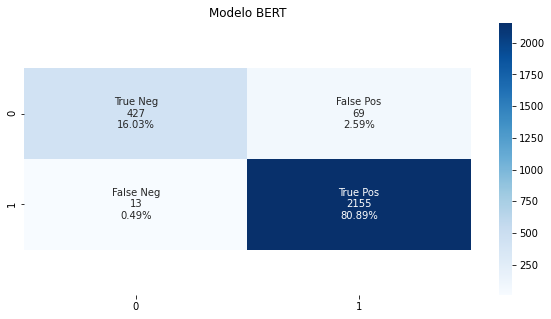

---> Nombre Modelo:  Modelo BERT

Accuracy:  0.9692192192192193

Recall:  0.9940036900369004

F1-Score:  0.9813296903460839

Precision:  0.9689748201438849



In [ ]:
evaluar_modelo(model_mod_samp, 'Modelo BERT', True)

# Modelo Final

In [ ]:
_, bert_prob = clasificar(BERT_modelo)

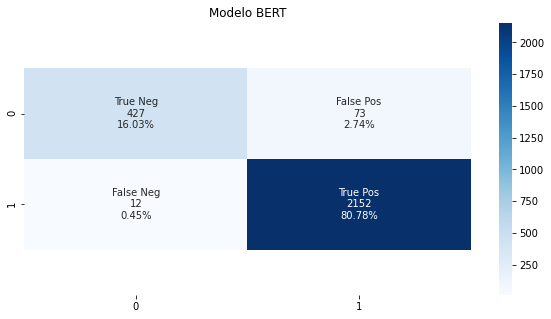

---> Nombre Modelo:  Modelo BERT

Accuracy:  0.9680930930930931

Recall:  0.9944547134935305

F1-Score:  0.9806334016860333

Precision:  0.9671910112359551



In [ ]:
evaluar_modelo(BERT_modelo, 'Modelo BERT', True)

In [ ]:
train_data

<PrefetchDataset shapes: ({input_word_ids: (32, 128), input_mask: (32, 128), input_type_ids: (32, 128)}, (32,)), types: ({input_word_ids: tf.int32, input_mask: tf.int32, input_type_ids: tf.int32}, tf.int32)>

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
r_probs = [0 for _ in range(len(y_test))]
redes_BERT = bert_prob
bert_auc = roc_auc_score(y_test, redes_BERT)
print('Modelo Red Neuronal BERT: AUROC = %.3f' % (bert_auc))

Modelo Red Neuronal BERT: AUROC = 0.995


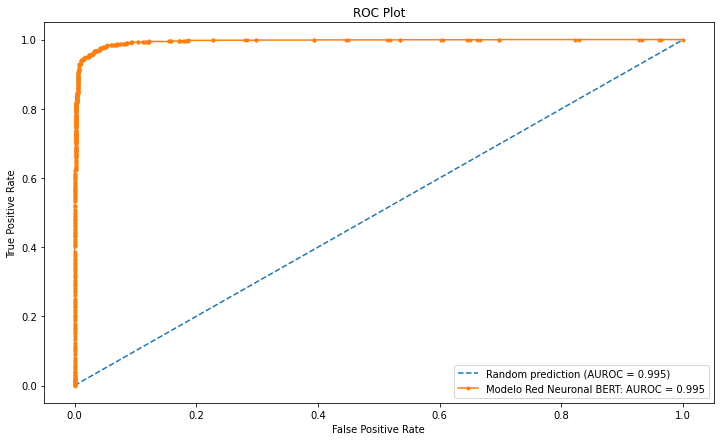

In [ ]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
redes_bert_fpr, redes_bert_tpr, _ = roc_curve(y_test, redes_BERT)

plt.figure(figsize=(12,7))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(redes_bert_fpr, redes_bert_tpr, marker='.', label='Modelo Red Neuronal BERT: AUROC = %.3f' % bert_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
list([bert_auc])

[0.9949912199630315]

In [ ]:
np.savetxt("redes_bert_fpr.csv", redes_bert_fpr, delimiter=",")
np.savetxt("redes_bert_tpr.csv", redes_bert_tpr, delimiter=",")
np.savetxt("bert_auc.csv", list([bert_auc]), delimiter=",")

In [ ]:
model_mod_samp.save('ModeloBERT.h5')

# Exportar probabilidades

In [ ]:
modelo_final = tf.keras.models.load_model('Modelos/ModeloBERT.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
X_test_bert = pd.read_csv('X_test_bert.csv', sep=',',header=None)
X_test_bert = X_test_bert.values

y_test_bert = pd.read_csv('y_test_bert.csv', sep=',',header=None)
y_test_bert = y_test_bert.values

In [ ]:
X_test_bert

<BatchDataset shapes: ({input_word_ids: (None, 128), input_mask: (None, 128), input_type_ids: (None, 128)}, (None,)), types: ({input_word_ids: tf.int32, input_mask: tf.int32, input_type_ids: tf.int32}, tf.int32)>

In [ ]:
X_test_bert = tf.data.Dataset.from_tensor_slices((X_test_bert, [0]*len(X_test_bert)))
X_test_bert = (X_test_bert.map(to_feature_map).batch(1))

In [ ]:
X_test_bert = (X_test_bert.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

TypeError: ignored

In [ ]:
_ , prob = clasificar(modelo_final, X_test_bert)

InvalidArgumentError: ignored

In [ ]:
np.savetxt("prob_BERT.csv", prob, delimiter=",")

# Estructura Modelo BERT Final

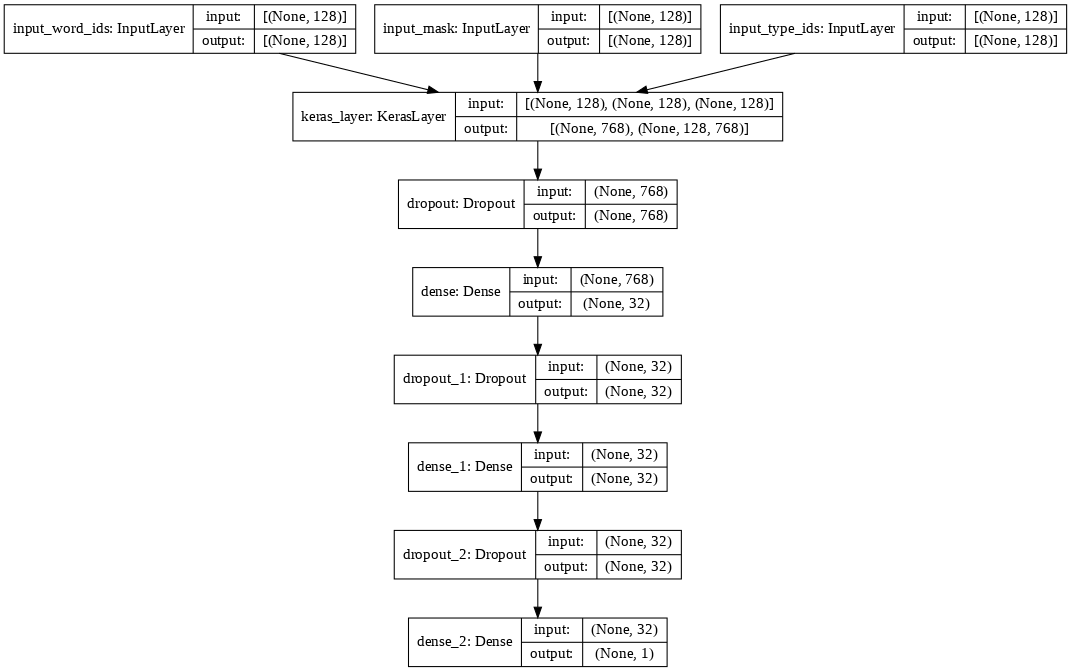

In [ ]:
tf.keras.utils.plot_model(model=model_mod_samp, show_shapes=True, dpi=76)